# Weather analysis - French coast

This notebook aims at highlighting interesting statistics about weather in famous places along the French coasts.

The historical data comes from this Russian [website](https://rp5.ru/Weather_in_France), and corresponds to meteorological stations in French coastal airports, which are part of the METAR meterological network (list of French METAR stations available [here](https://fr.allmetsat.com/metar-taf/france.php?icao=LFRZ)).

## Meteo

### Preprocessing

In [39]:
import pandas as pd
#import numpy as np
#import datetime
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns

In [2]:
# variables to rename
variables = {'year':'year',
             'month':'month',
             'day':'day',
             'hour':'hour',
             'WW':'comments',
             'T':'temp',
             'Po':'pressure',
             'U':'humid',
             'Ff':'windspeed',
             'VV':'visib',
             'N':'cloudcover',
             'H':'cloudsheight',
             'RRR':'precip',
            }

In [3]:
# strings to replace with values
replacements = {'Trace of precipitation':0.1,
                'No precipitation':0,
                '100%.':100,
                '90  or more, but not 100%':90,
                '70 – 80%.':75,
                '60%.':60,
                '50%.':50,
                '40%.':40,
                '20–30%.':25,
                'no clouds':0,
                '10%  or less, but not 0':5,
                'Sky obscured by fog and/or other meteorological phenomena.':100,
                '2500 or more, or no clouds.':0,
                '2000-2500':2250,
                '1500-2000':1750,
                '1000-1500':1250,
                '600-1000':800,
                '300-600':450,
                '200-300':250,
                '100-200':150,
                '50-100':100,
                'Less than  50':50,
                'less than 0.1':50
               }

In [4]:
def round_to_nearest_k(x, k):
    return int(k * round(float(x)/k))

In [27]:
def preprocess(city_name):
    
    # concatenate all files related to city_name
    city_data = []
    for file in glob.glob('{}/20*.xls'.format(city_name)):
        df = pd.read_excel(file, header=6)
        df = df.iloc[::-1] # reverse order of rows to be chronological
        city_data.append(df) # store dataframe in a list
    df = pd.concat(city_data, ignore_index=True)

    # datetime transformations
    df.rename(columns={df.columns[0]: "time"}, inplace = True)
    df.time = pd.to_datetime(df.time)
    df['year'] = df.time.dt.year
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['hour'] = df.time.dt.hour
    df.drop(columns=['time'], inplace=True)

    # select the hours we want
    hours_1 = df['hour'] >= 9
    hours_2 = df['hour'] <= 21
    df = df[hours_1 & hours_2]

    # select the variables we want
    df = df[variables.keys()]
    df.rename(columns=variables, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # replace string comments with numbers
    df.replace(to_replace=replacements, inplace=True)
    df.replace(to_replace='Cloud development not observed or not observable. ', value=' ', inplace=True)

    # fill in missing values with linear interpolation
    to_interpolate = df.columns[-8:] 
    df[to_interpolate] = df[to_interpolate].apply(pd.to_numeric)
    df[to_interpolate] = df[to_interpolate].interpolate(method='linear', limit=None)
    df[to_interpolate] = df[to_interpolate].fillna(method='bfill', limit=None) # in case nan is the first index
    df[to_interpolate] = df[to_interpolate].fillna(method='ffill', limit=None) # in case nan is the last index

    # round values
    df = df.round(1)
    df.visib = df.visib.round(0)
    df.cloudcover = df.cloudcover.apply(lambda x: round_to_nearest_k(x, k=5))
    df.cloudsheight = df.cloudsheight.apply(lambda x: round_to_nearest_k(x, k=50))
    
    # add boolean indicators
    df['precip_bool'] = df['precip'].mask(cond=df['precip']>0, other=1)
    
    return df

In [28]:
df = preprocess('Biarritz')
print(df.shape)
df.head(20)

(28398, 14)


,year,month,day,hour,comments,temp,pressure,humid,windspeed,visib,cloudcover,cloudsheight,precip,precip_bool
0,2014,1,1,9,,11.9,752.8,61.0,4.0,60.0,40,1750,0.0,0.0
1,2014,1,1,10,,12.8,752.7,56.0,4.0,60.0,90,0,0.0,0.0
2,2014,1,1,11,,13.3,752.5,55.0,5.0,60.0,90,0,0.0,0.0
3,2014,1,1,12,,14.0,752.5,53.0,4.0,60.0,90,0,0.0,0.0
4,2014,1,1,13,,14.8,751.9,51.0,4.0,60.0,90,0,0.0,0.0
5,2014,1,1,14,,15.0,751.3,51.0,5.0,55.0,90,0,0.0,0.0
6,2014,1,1,15,"Rain, not freezing, intermittent, slight at ti...",12.9,750.6,66.0,5.0,13.0,90,2250,0.6,1.0
7,2014,1,1,16,Rain (not freezing) not falling as shower(s).,13.9,749.8,60.0,5.0,60.0,90,2250,0.6,1.0
8,2014,1,1,17,,14.3,749.5,59.0,5.0,60.0,90,2250,0.0,0.0
9,2014,1,1,18,,14.5,748.9,57.0,5.0,60.0,90,2250,0.0,0.0


In [29]:
# check missing values
df.isna().sum()

year            0
month           0
day             0
hour            0
comments        0
temp            0
pressure        0
humid           0
windspeed       0
visib           0
cloudcover      0
cloudsheight    0
precip          0
precip_bool     0
dtype: int64

In [30]:
# check values for one of the variables
x = df.visib.unique()
x = np.sort(x)
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 65., 70., 71.])

### Analysis

#### Temperature

#### Precipitations

Bar plot: cumulated precipitations

In [40]:
sns.set_palette('GnBu')
plt.style.use('seaborn-dark')

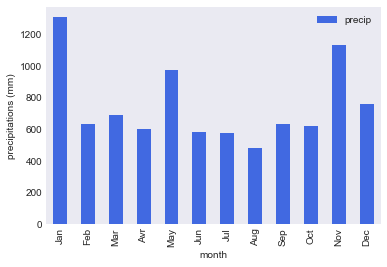

In [56]:
df.groupby(df['month']).sum().filter(items=['precip']).plot(kind='bar', color='royalblue')
plt.xticks(np.arange(0,12, step=1), ['Jan','Feb','Mar','Avr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('precipitations (mm)');

Line plot: comparison of all cities' cumulated precipitations (potentially stackplot)

Bubble plot: nb of days of precipitation (size of bubble) and cumulated precipitations (y-axis).

In [ ]:
# compute most common themes when only keeping ==3

topthemes = data[data.columns[-16:]]
topthemes.drop(columns = ['author', 'author gender', 'century', 'quarter century','date'], inplace=True)
topthemes[topthemes < 3] = 0 # keep only the most relevant theme per row
topthemes[topthemes == 3] = 1 # set it to 1 to count
topthemes = pd.DataFrame(topthemes.sum())
topthemes.reset_index(inplace=True)
topthemes.rename(columns = {topthemes.columns[0]:'content', topthemes.columns[1]:'sum'}, inplace=True)

top_themes = pd.merge(df, topthemes, on='content')
top_themes['y_percentage'] = top_themes['sum_y']/data.shape[0]*100
top_themes['y_percentage'] = top_themes['y_percentage'].astype(int).astype(str) + '%'
top_themes

In [ ]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(14,5))
xrange = range(len(top_themes['content']))
# equivalent to np.arange(len(top_themes['content']))
# and to range(0,top_themes.shape[0])

plt.scatter(x=xrange, y=top_themes['sum_x'], s=top_themes['sum_y']*51,
            c='xkcd:dark periwinkle', alpha=0.9)
# equivalent to ax = sns.scatterplot(same)

plt.xticks(np.arange(0, 11, step=1))
ax.set_xticklabels(top_themes['content'], fontweight='semibold')
plt.ylabel("Axis: total sum of occurences in sample \n Bubbles: % of occurences as major plot topic ('3')", fontweight='semibold')
plt.title('Top science fiction themes in literature since the early XIXth century', fontweight='bold', fontsize = '14')
plt.grid(True, axis = 'x', color='xkcd:warm blue', linestyle=':', linewidth=0.9, alpha=0.8)

for line in range(0,top_themes.shape[0]):
     ax.text(xrange[line], top_themes.sum_x[line]-2.2, top_themes.y_percentage[line], 
             horizontalalignment='center', size='medium', color='xkcd:off white', weight='normal')
# works as well with top_themes.sum_x.iloc[line] and top_themes.sum_y.iloc[line]

plt.show()

## Coordinates

I obtained coordinates (DMS, convertible to DD with this [tool](https://www.latlong.net/degrees-minutes-seconds-to-decimal-degrees)) of METAR stations through this [website](https://www.aviationweather.gov/docs/metar/stations.txt).

In [10]:
coordinates = {'Biarritz':(43.47, -1.52),
               'Arcachon':(44.52, -1.12),
               'Deauville':(49.37, 0.15),
               'Dinard':(48.58, -2.07),
               'Hyères':(43.10, 6.15),
               'Lorient':(47.77, -3.45),
               'St-Nazaire':(47.32, -2.17),
               'Nice':(43.63, 7.20),
               'La Rochelle':(46.18, -1.20),
               'Le Touquet':(50.52, 1.62),
               'Agde':(43.32,3.35),
               'Ajaccio':(41.92,8.80)
              }

In [11]:
# Convert to geo dataframe
coordinates = pd.DataFrame(coordinates).T
coordinates.columns = ['lat', 'lon']
coordinates['geometry'] = list(zip(coordinates['lon'], coordinates['lat']))
coordinates['geometry'] = coordinates['geometry'].apply(lambda x: Point(x))
coordinates = gpd.GeoDataFrame(coordinates, crs={'init': 'epsg:4326'}) # WSG84
coordinates.head(3)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,lat,lon,geometry
Biarritz,43.47,-1.52,POINT (-1.52000 43.47000)
Arcachon,44.52,-1.12,POINT (-1.12000 44.52000)
Deauville,49.37,0.15,POINT (0.15000 49.37000)


In [12]:
# Grab FR outline
fr_outline = gpd.read_file('/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Data/OSM_coord/FRA_adm/FRA_adm2.shp')

In [13]:
# Change CRS for nicer display
coordinates = coordinates.to_crs(epsg=27700)
fr_outline = fr_outline.to_crs(epsg=27700)

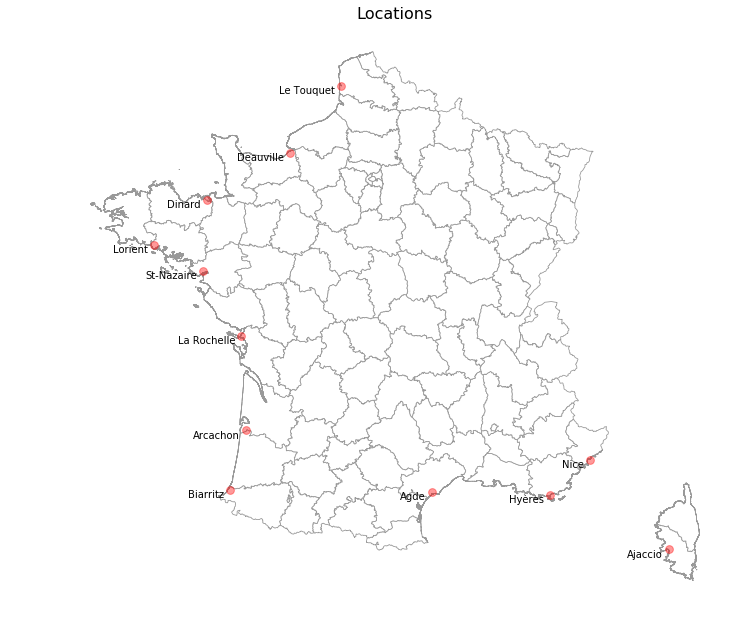

In [14]:
# Plot
fig, ax = plt.subplots(1, figsize=(12, 12))
fr_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
coordinates.plot(ax=ax, markersize=60, color='red', alpha=0.4)

for x, y, label in zip(coordinates.geometry.x, coordinates.geometry.y, coordinates.index):
    ax.annotate(label, xy=(x, y), xytext=(-6, -8), horizontalalignment='right', textcoords="offset points")

ax.set_title("Locations", fontdict={'fontsize':'16', 'fontweight' :'4'})
ax.axis('off')
plt.show();

## Sea Surface Temperature

One of the most famous and comprehensive dataset for Sea Surface Temperature (SST) is the ERSST dataset, collected by the NOAA and available through this [link](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5). The problem is it comes in ASCII or NetCDF gridded data format, which is not easy to manipulate with python. As a consequence, I used directly computed temperature means and history per location through the [seatemperature.info](https://seatemperature.info/july/france-water-temperature.html) website.

In [15]:
def slice_temp(x):
    return x[:1] if len(x)<4 else x[:2]

In [16]:
sst = pd.read_excel('SST.xlsx', header=1, index_col=0)
sst = sst.applymap(lambda x: slice_temp(x))
sst

,Arcachon,Biarritz,Deauville,Agde,Dinard,Hyères,Lorient,Nazaire,Nice,Rochelle,Touquet,Ajaccio
Jan,12,12,8,12,9,14,10,9,14,10,8,14
Feb,11,12,7,11,8,14,10,9,14,9,7,13
Mar,11,12,8,12,8,13,10,10,14,10,7,14
Apr,13,14,10,14,10,14,11,12,15,12,9,15
May,15,15,13,16,12,16,13,14,17,15,12,17
June,18,19,15,19,15,20,16,16,21,18,15,21
July,20,21,18,21,17,23,18,18,24,20,17,24
Aug,21,22,19,22,18,24,18,19,25,20,18,25
Sept,20,21,18,20,18,22,17,17,23,19,17,23
Oct,18,18,16,19,16,20,16,16,21,17,16,21


Radar plot: average in the summer months

In [ ]:
# Most frequent content for men authors

data_men = data[data.columns[-12:]]
index_women = data_men[ data_men['author gender'] == 2 ].index
data_men.drop(index_women, inplace=True)
data_men.drop(columns = ['author gender'], inplace=True)
content_men = data_men.sum()

content_men = pd.DataFrame(content_men)
content_men.reset_index(inplace=True)
content_men.rename(columns = {content_men.columns[0]:'content', content_men.columns[1]:'sum'}, inplace=True)

content_men['occurences'] = [x for x in data_men.astype(bool).sum(axis=0)] # count non-zeros in columns
content_men['percentage'] = content_men['occurences']/data_men.shape[0]*100
content_men['percentage'] = content_men['percentage'].astype(int)
# to add the % symbol, add at the end of previous line: .astype(str) + '%'
content_men

In [ ]:
labels = data_men.sum().keys() # or: labels=content_men['content'].values
stats = content_men['percentage'].values # .values needed to have it as array and not df

In [ ]:
def spiderplot(labels, stats):
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    fig=plt.figure(figsize = (7,7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, color='cornflowerblue')
    ax.fill(angles, stats, alpha=0.25, color = 'royalblue')
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title('Most frequent themes for men authors (in % books)', fontweight="bold", fontsize = 13)
    ax.grid(True)
    return ax

spiderplot(labels, stats)
plt.show()

Line plot: comparison over the year

## Conclusion

Horizontal cumulated bar chart with comparison of main items for all cities

In [ ]:
# create a dictionary with for each theme the total nb of occurences of other themes

content = data[data.columns[-11:]]
dict_contents = {}

for col in content.columns:
    
    # first build a table with only rows for which col isn't null
    content = data[data.columns[-11:]]
    index = content[ content[col] == 0 ].index
    content.drop(index, inplace=True)
    content[col].values[:] = 0 # make sure to keep col, but with 0s only (for graph)
    
    # then count the sum of marks in each of the the remaining columns
    dict_col = [content[remaining_col].sum() for remaining_col in content.columns]
    # to keep the key name: dict_col = {k: v/sum(dict_col.values())*100 for k, v in dict_col.items()}

    # compute the percentage this count represents
    dict_col = dict_col/sum(dict_col)
    
    # add to dict_contents
    dict_contents[col] = dict_col

dict_contents

In [ ]:
# display as horizontal bar chart

category_names = dict_contents.keys()
labels = list(dict_contents.keys())
data = np.array(list(dict_contents.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(14, 7))
#ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    xcenters = starts + widths / 2

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        # next 4 lines added to avoid showing a 0.0 label for row theme
        cbis = y+c
        c = round(c*100, ndigits=1)
        if (cbis).is_integer():
            c=""
        ax.text(x, y-0.03, str(c), ha='center', va='center', color=text_color)

ax.legend(ncol=6, bbox_to_anchor=(0, 1), loc='lower left', fontsize='medium')
plt.title('For each theme, percentage of occurence of other themes',
          fontweight="semibold", fontsize = 'large', y=-0.07)
plt.show()

## Examples from other notebook

In [8]:
wx = bq.Query(wxquery, year=2015).to_dataframe()
wx[:5]

,date,prcp,tmin,tmax,haswx
0,2015-01-01,0.0,-9.9,0.0,False
1,2015-01-02,0.0,-9.3,1.1,False
2,2015-01-03,14.5,-1.6,1.1,True
3,2015-01-04,3.3,-16.6,0.6,True
4,2015-01-05,3.8,-19.3,-14.3,True


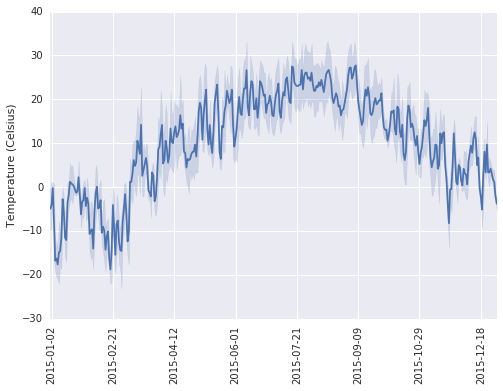

In [9]:
# Plot the average value
ax = (0.5*(wx['tmin']+wx['tmax'])).plot()
x = np.arange(len(wx.date))
palette = sns.color_palette()
ax.fill_between(x, wx['tmin'].values, wx['tmax'].values, alpha=.2, color=palette.pop(0))
ax.set_ylabel("Temperature (Celsius)")
import matplotlib.ticker as plticker
junk = plt.xticks(x[1::50], wx['date'].values[1::50], rotation='vertical')

In [11]:
airwx = bq.Query(airwxquery).to_dataframe()
airwx[:5]

,wx_date,wx_prcp,f_departure_delay,f_arrival_airport
0,2005-04-01,3.8,-4.0,DCA
1,2005-04-02,0.8,-5.0,DCA
2,2005-04-03,0.0,20.0,DCA
3,2005-04-04,0.0,-5.0,DCA
4,2005-04-05,0.0,-3.0,DCA


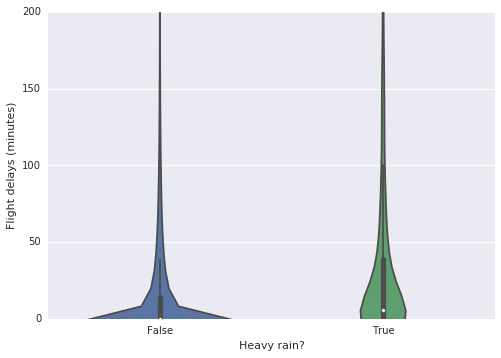

In [12]:
rainyday = airwx.wx_prcp > 25.4 # 1 inch of rain
ax = sns.violinplot(x=rainyday, y=airwx.f_departure_delay)
ax.set_ylim(0, 200)
ax.set_xlabel('Heavy rain?')
ax.set_ylabel('Flight delays (minutes)')

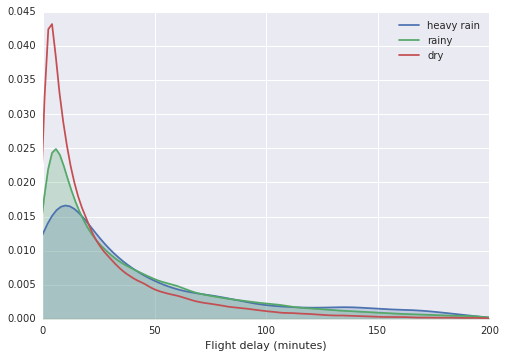

In [13]:
limited = airwx[airwx.f_departure_delay > 0]
limited = limited[limited.f_departure_delay < 200]
heavy = limited.wx_prcp > 25.4 # 1 inch of rain
rainy = limited.wx_prcp > 0
ax = sns.kdeplot(limited.f_departure_delay[heavy], shade=True, label='heavy rain')
ax = sns.kdeplot(limited.f_departure_delay[rainy], shade=True, label='rainy')
ax = sns.kdeplot(limited.f_departure_delay[np.logical_not(rainy)], shade=False, label='dry')
ax.set_xlim(0,200)
ax.set_xlabel('Flight delay (minutes)')